# Sentiment Analysis of Twitter Data

### installing required libraries
twint library used for colliction data from twitter without API.

In [1]:
!pip install twint
!pip install --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
#this prevents async problems/ runtime errors
!pip install nest_asyncio

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.7/263.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.3/385.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.8 MB/s eta 0:00:00
  Created wheel for twint: filename=twint-2.1.20-py3-none-any.whl size=33929 sha256=8b4c44051d8875bdd0b87eb9dfc7e4f7dd1d5926347c0a09f36c27314d11cd36
  Stored in directory: /root/.cache/pip/wheels/44/fc/77/99887a36b5c265a87516158858697d1a0b8f32c4d4dbddbb24
  Created wheel for googletransx: filename=googletransx-2.4.2-py3-none-any.whl size=15968 sha256=365c4fe35a77bd333ebdc952564823be1593e25b4d345aa0dd1ed598d43edf48
  Stored 

### import required libraries

In [2]:
import twint
import nest_asyncio
nest_asyncio.apply()
import json
import re
from nltk import ngrams
import csv
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # for plot styling

### Collection data
Instantiate and configure the twint-object for get data from twitter.


In [3]:
c = twint.Config()
c.Store_object = True
c.Pandas =True
c.Search = "#سياحة"
# c.Since = '2022-01-01'
# c.Until = '2022-11-30'
c.Limit = 100
c.Lang = 'ar'
c.Filter_retweets = False
c.Store_json = True
c.Output = "1_tweets.json"
twint.run.Search(c)
# Quick check
# twint.storage.panda.Tweets_df.head(20)

1605561887231549440 2022-12-21 13:52:38 +0000 <gtravel001> #سياحة  Georgia Travels Tourism Company trips   for families, youth and grooms  ✔ driver with private cars  ✔ reception from Tbilisi airport tourist guide in Georgia 🇬🇪 WhatsApp📱 00995599997016 #جديد_المجد   #السياحة_العلاجية ✅ 🏥  #جورجيا  https://t.co/o8cKdGRjGZ
1605555954879451137 2022-12-21 13:29:04 +0000 <_1llilo> #تبليسى #جورجيا #جورجيا_تبليسي #سياحة #عطلات #اجازة #سافر #رحلات_طوال_العام #رحلات #عوايل #عوائل #للحجز #عروض #السعودية #عدستى #قطر #الامارات #البحرين #عمان #باتومي #المسافرون_العرب #المسافرون #سياحةوسفر #جورجيا_بعيون_عربية #السياحة_في_جورجيا  https://t.co/dttQSNnRhF
1605555710804123649 2022-12-21 13:28:05 +0000 <Formula_KSA> -  كمل فرحتك و #فورمولا ترتب رحلتك واحلى هدايا من فورمولا للعرسان 💜 🎁   ✈️🌍. ____  #formula_ksa  @formula_ksa  #باكجات_شهر_العسل_مع_فورمولا   #سياحة #سفر #شهرالعسل #سياحة_سفر #شهر_العسل #جزرالمالديف #المالديف #بالي #ماليزيا #البوسنة #تايلند #موريشيوس #سيشل  https://t.co/tKW4nSZeiL
16055548578

## 1- Loading and Cleaning Twitter Data

In [4]:
# Open the input file
input_file = open('/kaggle/input/sentiment-arabic-tweets/1_tweets.json','r', encoding="utf-8")
clean_tweets = open('/kaggle/working/clean_tweets.txt','w')

# Load the first few lines
for line in input_file:
    tweet = json.loads(line)
    temp = re.sub("@[A-Za-z0-9_]+","@User", tweet['tweet'])
    temp = re.sub(r"http\S+", "URL", temp)
    temp = re.sub(r"www.\S+", "URL", temp)
    temp = re.sub('[()!\'?]', '', temp)
    temp = re.sub('\[.*?\]','', temp)
    temp = re.sub("[^أ-يA-z0-9@]"," ", temp)
    clean_tweets.write(temp + '\n')

# Close the input files
input_file.close()
clean_tweets.close()

## 2- Derive the sentiment of each tweet

put the lexicon/Afinn file in dict as {term:score}

In [5]:
afinnfile = open("/kaggle/input/sentiment-arabic-tweets/3_Afinne_arabic.csv", 'r', encoding="utf-8")
scores = {} # initialize an empty dictionary
for line in afinnfile:
    line = line.strip()
    term = line.split(',')[0]
    score = line.split(',')[1]
    try:
        scores[term] = float(score) # Conver the score to an integer. It was parsed as a string.
    except:
        None
afinnfile.close()
print(len(scores))
# print(scores.items( )) # Print every (term, score) pair in the dictionary

42772


- make score for each tweets in sentiment file
- make newWords dectionary for words that not exist in afinne file

In [6]:
tweets = open("/kaggle/working/clean_tweets.txt", 'r', encoding="utf-8")
sentiments = open("/kaggle/working/3_sentiment.txt", 'w', encoding="utf-8")
newWords = {}
for line in tweets:
    line = line.strip()
    total_score = 0
    for word in line.split(' '):
        wordScore = scores.get(word, 0)
        total_score = total_score + wordScore
        if wordScore == 0 and word != 'URL' and word != 'User':
            newWords[word] = newWords.get(word, 0)
    sentiments.write(str(round(total_score, 3)) + "\n")        
tweets.close()
sentiments.close()
print(len(newWords))

3573


give score for new words in newWords dictionary

In [7]:
tweets = open("/kaggle/working/clean_tweets.txt", 'r', encoding="utf-8")
sentiments = open("/kaggle/working/3_sentiment.txt", 'r', encoding="utf-8")
result = open("/kaggle/working/3_stdout.txt", 'w', encoding="utf-8")

tweets_scores = sentiments.read().split('\n')
word_score = None
for word in newWords.keys():
    word_score = 0
    index = 0
    for line in tweets:
        line = line.split(' ')
        if word in line:
            word_score += float(tweets_scores[index].strip())
        index += 1
    if word_score > 0:
        newWords[word] = 1
    elif word_score < 0:
        newWords[word] = -1
    else:
        newWords[word] = 0
    result.write(word +' '+ str(newWords[word]) +'\n')
    tweets.seek(0)
tweets.close()
print(newWords)

{'ميسي': -1, 'وينه': -1, 'العراق': -1, 'الصدر': -1, 'عشاق': -1, 'قاموا': -1, 'بإنشا': -1, 'يسمح': -1, 'لك': -1, 'بمعرفة': -1, 'المسافة': -1, 'والملاكم': -1, 'المكسيكي': -1, 'ساول': -1, 'الفاريز': -1, 'والموقع': -1, 'يحدد': -1, 'بأمان': -1, 'حاليا': -1, 'بينهما': -1, 'تشير': -1, 'إلى': -1, 'الأمان': -1, 'كأس_العالم_قطر_2022': -1, 'مونديال_قطر_2022': -1, 'الارجنتين': -1, 'Messi': -1, 'كأس_العالم': -1, 'السعوديه_المكسي': -1, 'يتقابون': -1, 'الممشى': -1, 'الليل': -1, 'حديثي': -1, 'لقناة': -1, 'الجزيرة': -1, 'كسرنا': -1, 'عينه': -1, 'واليوم': -1, 'إيران': -1, 'أمريكا': -1, '@User': -1, 'Qatar2022': -1, 'قطر_كأس_العالم_2022': -1, 'MAMA2022': -1, 'قالوا': -1, 'يهمنا': -1, 'فعلته': -1, 'حياتك': -1, 'حياتنا': -1, 'اخبرونا': -1, 'احمد_حسام_ميدو': -1, 'الشركة': -1, 'الراعية': -1, 'للنجم': -1, 'الأرجنتيني': -1, 'ولو': -1, 'الهدف': -1, 'لرونالدو': -1, 'سيتخطى': -1, 'الحين': -1, 'الطريقه': -1, 'أكيد': -1, 'عندنا': -1, 'المقاهي': -1, 'الأخضر': -1, 'وطبيعي': -1, 'يشوف': -1, 'على': -1, 'الجوال': -1, 'ن

## 3- feature extraction
- N-grams are continuous sequences of words or symbols or tokens in a document.
- They come into play when we deal with text data in NLP(Natural Language Processing) tasks.
- من البيانات التي قمنا بإنشائها وتصفيتها feature نعمل هنا على استخراج ال 

In [8]:
tweets = open("/kaggle/working/clean_tweets.txt", 'r', encoding="utf-8")
afinnfile = open("/kaggle/input/sentiment-arabic-tweets/3_Afinne_arabic.csv", 'r', encoding="utf-8")
f = open("/kaggle/working/featuresAndLabels.csv", 'w',newline='',encoding='utf-8-sig')
writer = csv.writer(f)

scores = {} # initialize an empty dictionary
for line in afinnfile:
    line = line.strip()
    term = line.split(',')[0]
    score = line.split(',')[1]
    try:
        scores[term] = float(score) # Conver the score to an integer. It was parsed as a string.
    except:
        None
afinnfile.close()

# Function to extract lexicon items
def extract(g, lex):
    if ' '.join(g) in lex.keys():
        return lex.get(' '.join(g))
    elif g[0] in lex.keys():
        return lex.get(g[0])
    else:
        pass

# Your task
mylist = list()
mylist.append(['tweet', 'feature'])
for line in tweets:
    line = line.strip()
    out = [extract(g, scores) for g in ngrams(line.split(), 2) if extract(g, scores)]
    out = sum(out)
    if out > 0:
        mylist.append([line,"positive"])
    elif out < 0:
        mylist.append([line,"negative"])
    else:
        mylist.append([line,"neutral"])
writer.writerows(mylist)
tweets.close()
f.close()

## 4- Training and Testing By SVM
-  للتأكد أن البيانات التي سنقوم بتدريبها صحيحة ،feature نقوم باستخدام بيانات جاهزة لاستخراج ال

In [9]:
df = pd.read_csv('/kaggle/input/sentiment-arabic-tweets/4_AT-ODTSA_Dataset_RawDataV1-1.csv')
X=df['tweet'].values
y=df['sentiment'].values

# Split the tweets into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['sentiment'], test_size=0.2)

# Convert the tweets into numerical features
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Train the SVM model
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Test the model on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = sum(y_pred == y_test) / len(y_test)
print(f"Accuracy score is {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy score is 0.56
              precision    recall  f1-score   support

          -1       0.52      0.49      0.50       171
           0       0.58      0.57      0.58       207
           1       0.57      0.60      0.59       222

    accuracy                           0.56       600
   macro avg       0.56      0.55      0.56       600
weighted avg       0.56      0.56      0.56       600



## 5- Drow scatter plot

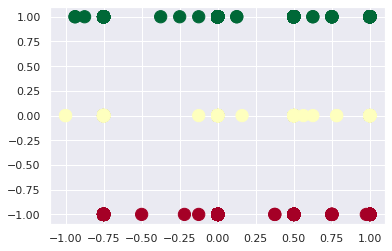

In [10]:
def polarity(text):
    return TextBlob(text).sentiment.polarity
df['polarity'] = df['tweet'].apply(polarity)
X = df['polarity']
y = df['sentiment']
plt.scatter(X, y, c=y, s=150, cmap='RdYlGn')